✓ Loaded 642 trades
✓ Loaded 321 completed trades
✓ Loaded 9714739 market data rows

⏳ Reconstructing trades with context...
✓ Reconstructed 319 trades with full context

CRITICAL TRADE ATTRIBUTION ANALYSIS

Winners: 158 (49.5%)
Losers: 161 (50.5%)

sol_in_curve:
  Winners: 149.2882 ± 92.2363
  Losers:  141.6613 ± 95.2755
  T-stat:  0.73 (p=0.4682) 
  Effect:  0.08 (Cohen's d)

cvd_slope:
  Winners: -3.6519 ± 10.7534
  Losers:  -3.3889 ± 9.5313
  T-stat:  -0.23 (p=0.8173) 
  Effect:  -0.03 (Cohen's d)

cvd_momentum:
  Winners: 449434.9309 ± 3357186.2848
  Losers:  -118020.8104 ± 4449920.0371
  T-stat:  1.28 (p=0.2001) 
  Effect:  0.14 (Cohen's d)

volume_surge_ratio:
  Winners: 1.0697 ± 0.7107
  Losers:  0.9991 ± 0.7057
  T-stat:  0.89 (p=0.3744) 
  Effect:  0.10 (Cohen's d)

trade_size_cv:
  Winners: 1.6758 ± 0.5676
  Losers:  1.6966 ± 0.6633
  T-stat:  -0.30 (p=0.7640) 
  Effect:  -0.03 (Cohen's d)

price_vs_sma:
  Winners: -0.0013 ± 0.0795
  Losers:  0.0085 ± 0.1273
  T-stat:  -0.82

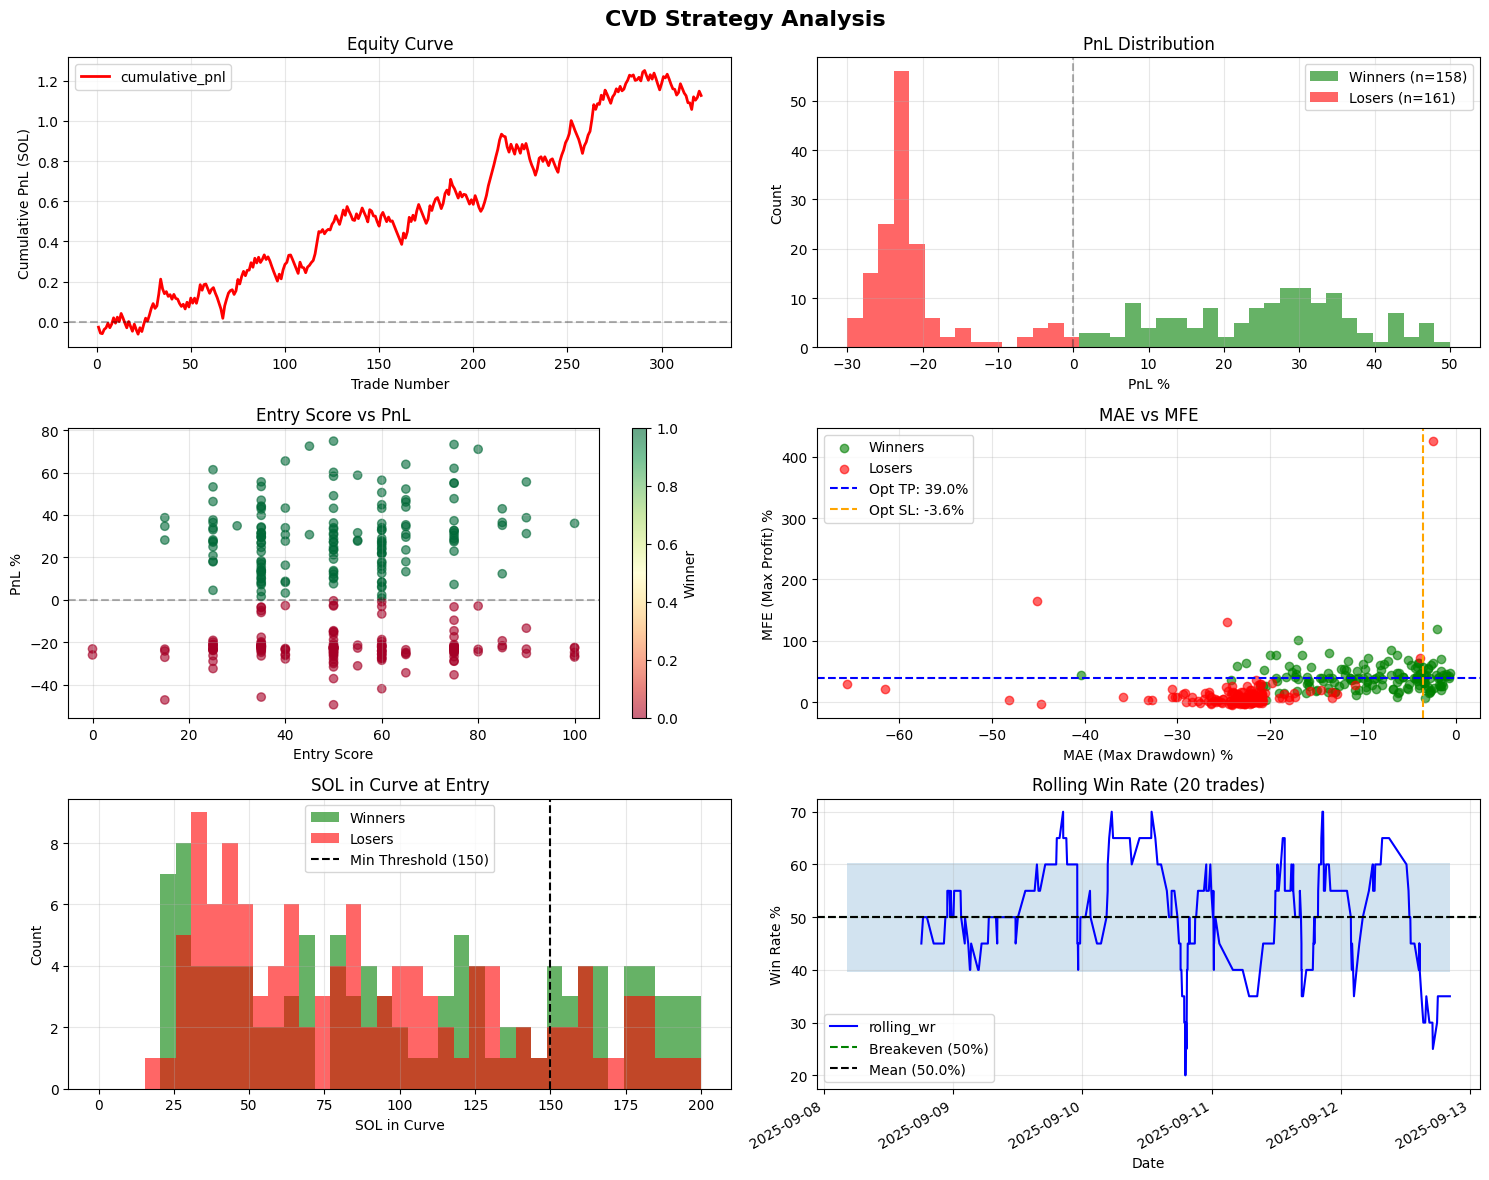

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta

# ============================================================================
# PART 1: LOAD AND PARSE DATA
# ============================================================================

def load_backtest_results(filepath):
    """Parse the custom backtest format"""
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    # Find section markers
    trades_start = next(i for i, line in enumerate(lines) if line.startswith('#TRADES'))
    equity_start = next(i for i, line in enumerate(lines) if line.startswith('#EQUITY'))
    
    # Parse trades
    trades_lines = lines[trades_start+2:equity_start-1]
    trades_data = [line.strip().split(',') for line in trades_lines if line.strip()]
    trades_df = pd.DataFrame(trades_data, columns=[
        'token_address', 'timestamp', 'trade_type', 'price', 'sol_amount'
    ])
    
    # Parse equity curve
    equity_lines = lines[equity_start+2:]
    equity_data = [line.strip().split(',') for line in equity_lines if line.strip()]
    equity_df = pd.DataFrame(equity_data, columns=[
        'trade_number', 'token_address', 'exit_date', 'cumulative_pnl',
        'trade_pnl', 'trade_type', 'execution_latency_seconds'
    ])
    
    # Convert types
    trades_df['timestamp'] = pd.to_datetime(trades_df['timestamp'])
    trades_df['price'] = trades_df['price'].astype(float)
    trades_df['sol_amount'] = trades_df['sol_amount'].astype(float)
    
    equity_df['trade_number'] = equity_df['trade_number'].astype(int)
    equity_df['exit_date'] = pd.to_datetime(equity_df['exit_date'])
    equity_df['cumulative_pnl'] = equity_df['cumulative_pnl'].astype(float)
    equity_df['trade_pnl'] = equity_df['trade_pnl'].astype(float)
    
    return trades_df, equity_df

def load_market_data(filepath):
    """Load the raw market data"""
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    return df

# Load data
trades_df, equity_df = load_backtest_results('merged_trades/OrderFlowImbalanceStrategy_20251026_230332.csv')
market_df = load_market_data('/home/daksh/Downloads/pumpfun_09-08-2025_to_09-11-2025.csv/pumpfun_09-08-2025_to_09-11-2025.csv')

print(f"✓ Loaded {len(trades_df)} trades")
print(f"✓ Loaded {len(equity_df)} completed trades")
print(f"✓ Loaded {len(market_df)} market data rows")

# ============================================================================
# PART 2: RECONSTRUCT TRADE RECORDS WITH CONTEXT
# ============================================================================

def reconstruct_trades(trades_df, equity_df, market_df):
    """Match buys with sells and add market context"""
    
    trade_records = []
    
    for idx, row in equity_df.iterrows():
        token = row['token_address']
        exit_date = row['exit_date']
        
        # Find the corresponding buy
        token_trades = trades_df[trades_df['token_address'] == token].copy()
        token_trades = token_trades[token_trades['timestamp'] <= exit_date]
        
        # Get the last buy before this sell
        buys = token_trades[token_trades['trade_type'] == 'BUY']
        if len(buys) == 0:
            continue
            
        entry = buys.iloc[-1]
        
        # Calculate hold duration
        hold_duration = (exit_date - entry['timestamp']).total_seconds() / 3600  # hours
        
        # Get market context at entry
        entry_market = market_df[
            (market_df['Token Address'] == token) &
            (market_df['Date'] <= entry['timestamp'])
        ].tail(200)  # Last 200 trades before entry
        
        if len(entry_market) < 20:
            continue
        
        # Calculate entry metrics
        sol_in_curve = entry_market['SOL in Curve'].iloc[-1]
        
        # CVD calculation
        entry_market['signed_volume'] = entry_market.apply(
            lambda x: x['Token Amount'] if x['Transaction Type'] == 'Buy' else -x['Token Amount'],
            axis=1
        )
        
        # Recent CVD metrics
        recent_window = entry_market.tail(100)
        cvd_slope = calculate_cvd_slope(recent_window['signed_volume'].values, window=20)
        cvd_momentum = calculate_cvd_momentum(recent_window['signed_volume'].values)
        
        # Volume metrics
        avg_volume = entry_market['Token Amount'].tail(20).mean()
        recent_volume = entry_market['Token Amount'].tail(5).mean()
        volume_surge_ratio = recent_volume / avg_volume if avg_volume > 0 else 0
        
        # Trade size distribution (bot detection)
        trade_sizes = entry_market['Token Amount'].tail(20).values
        trade_size_cv = np.std(trade_sizes) / np.mean(trade_sizes) if np.mean(trade_sizes) > 0 else 0
        
        # Price metrics
        prices = entry_market['Token Price'].tail(20).values
        price_sma = np.mean(prices)
        price_vs_sma = (entry['price'] - price_sma) / price_sma
        
        # Calculate MFE/MAE (Maximum Favorable/Adverse Excursion)
        between_trades = market_df[
            (market_df['Token Address'] == token) &
            (market_df['Date'] >= entry['timestamp']) &
            (market_df['Date'] <= exit_date)
        ]
        
        if len(between_trades) > 0:
            max_price = between_trades['Token Price'].max()
            min_price = between_trades['Token Price'].min()
            
            mfe = (max_price - entry['price']) / entry['price']
            mae = (min_price - entry['price']) / entry['price']
        else:
            mfe = mae = 0
        
        # Exit price
        exit_price = float(row['trade_pnl']) / entry['sol_amount'] + entry['price'] if entry['sol_amount'] > 0 else entry['price']
        
        trade_records.append({
            'token_address': token,
            'entry_time': entry['timestamp'],
            'exit_time': exit_date,
            'entry_price': entry['price'],
            'exit_price': exit_price,
            'hold_hours': hold_duration,
            'pnl': row['trade_pnl'],
            'pnl_pct': (row['trade_pnl'] / entry['sol_amount']) * 100 if entry['sol_amount'] > 0 else 0,
            'exit_reason': row['trade_type'],
            
            # Market context
            'sol_in_curve': sol_in_curve,
            'cvd_slope': cvd_slope,
            'cvd_momentum': cvd_momentum,
            'volume_surge_ratio': volume_surge_ratio,
            'trade_size_cv': trade_size_cv,
            'price_vs_sma': price_vs_sma,
            'mfe': mfe,
            'mae': mae,
            
            # Outcomes
            'is_winner': row['trade_pnl'] > 0,
        })
    
    return pd.DataFrame(trade_records)

def calculate_cvd_slope(signed_volumes, window=20):
    """Calculate slope of CVD using linear regression"""
    if len(signed_volumes) < window:
        return 0
    
    recent = signed_volumes[-window:]
    cvd = np.cumsum(recent)
    
    x = np.arange(len(cvd))
    if len(x) < 2:
        return 0
    
    try:
        slope, _ = np.polyfit(x, cvd, 1)
        return slope / (np.mean(np.abs(cvd)) + 1e-10) * 100  # Normalized
    except:
        return 0

def calculate_cvd_momentum(signed_volumes):
    """Calculate momentum (acceleration) of CVD"""
    if len(signed_volumes) < 10:
        return 0
    
    recent = signed_volumes[-10:]
    slopes = []
    
    for i in range(2, len(recent)):
        window = recent[i-2:i+1]
        cvd = np.cumsum(window)
        x = np.arange(len(cvd))
        try:
            slope, _ = np.polyfit(x, cvd, 1)
            slopes.append(slope)
        except:
            pass
    
    if len(slopes) < 2:
        return 0
    
    # Return change in slope (acceleration)
    return slopes[-1] - slopes[0]

print("\n⏳ Reconstructing trades with context...")
trade_records_df = reconstruct_trades(trades_df, equity_df, market_df)
print(f"✓ Reconstructed {len(trade_records_df)} trades with full context")

# ============================================================================
# PART 3: CRITICAL ANALYSIS - TRADE ATTRIBUTION
# ============================================================================

print("\n" + "="*80)
print("CRITICAL TRADE ATTRIBUTION ANALYSIS")
print("="*80)

winners = trade_records_df[trade_records_df['is_winner'] == True]
losers = trade_records_df[trade_records_df['is_winner'] == False]

print(f"\nWinners: {len(winners)} ({len(winners)/len(trade_records_df)*100:.1f}%)")
print(f"Losers: {len(losers)} ({len(losers)/len(trade_records_df)*100:.1f}%)")

def compare_feature(feature_name, df, winners, losers):
    """Statistical comparison of feature between winners and losers"""
    
    winner_vals = winners[feature_name].dropna()
    loser_vals = losers[feature_name].dropna()
    
    if len(winner_vals) < 2 or len(loser_vals) < 2:
        return
    
    winner_mean = winner_vals.mean()
    loser_mean = loser_vals.mean()
    winner_std = winner_vals.std()
    loser_std = loser_vals.std()
    
    # T-test
    t_stat, p_value = stats.ttest_ind(winner_vals, loser_vals)
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt((winner_std**2 + loser_std**2) / 2)
    cohens_d = (winner_mean - loser_mean) / pooled_std if pooled_std > 0 else 0
    
    significance = "***" if abs(t_stat) > 2.5 else "**" if abs(t_stat) > 2.0 else "*" if abs(t_stat) > 1.5 else ""
    
    print(f"\n{feature_name}:")
    print(f"  Winners: {winner_mean:.4f} ± {winner_std:.4f}")
    print(f"  Losers:  {loser_mean:.4f} ± {loser_std:.4f}")
    print(f"  T-stat:  {t_stat:.2f} (p={p_value:.4f}) {significance}")
    print(f"  Effect:  {cohens_d:.2f} (Cohen's d)")
    
    if abs(cohens_d) > 0.5:
        direction = "HIGHER" if winner_mean > loser_mean else "LOWER"
        print(f"  → 🎯 WINNERS have {direction} {feature_name} (STRONG SIGNAL)")

# Run attribution analysis
features = [
    'sol_in_curve',
    'cvd_slope',
    'cvd_momentum',
    'volume_surge_ratio',
    'trade_size_cv',
    'price_vs_sma',
    'hold_hours'
]

for feature in features:
    compare_feature(feature, trade_records_df, winners, losers)

# ============================================================================
# PART 4: MAE/MFE ANALYSIS (STOP LOSS / TAKE PROFIT OPTIMIZATION)
# ============================================================================

print("\n" + "="*80)
print("MAE/MFE ANALYSIS - STOP LOSS & TAKE PROFIT OPTIMIZATION")
print("="*80)

# MAE Analysis (Stop Loss)
print("\n📉 MAE ANALYSIS (Stop Loss Optimization):")
winner_mae = winners['mae'].dropna() * 100
loser_mae = losers['mae'].dropna() * 100

mae_percentiles = [25, 50, 75, 90, 95]
print("\nWinners' MAE Distribution:")
for p in mae_percentiles:
    val = np.percentile(winner_mae, p)
    print(f"  {p}th percentile: {val:.2f}%")

optimal_stop = np.percentile(winner_mae, 75)
losers_saved = (loser_mae < optimal_stop).sum()
winners_killed = (winner_mae < optimal_stop).sum()

print(f"\n💡 RECOMMENDED STOP LOSS: {optimal_stop:.2f}%")
print(f"   Would save {losers_saved}/{len(loser_mae)} losers ({losers_saved/len(loser_mae)*100:.1f}%)")
print(f"   Would kill {winners_killed}/{len(winner_mae)} winners ({winners_killed/len(winner_mae)*100:.1f}%)")

# MFE Analysis (Take Profit)
print("\n📈 MFE ANALYSIS (Take Profit Optimization):")
winner_mfe = winners['mfe'].dropna() * 100
loser_mfe = losers['mfe'].dropna() * 100

print("\nWinners' MFE Distribution:")
for p in [25, 50, 75]:
    val = np.percentile(winner_mfe, p)
    print(f"  {p}th percentile: +{val:.2f}%")

optimal_tp = np.percentile(winner_mfe, 50)
print(f"\n💡 RECOMMENDED TAKE PROFIT: +{optimal_tp:.2f}%")

# Losers that were winning
losers_that_were_up = (loser_mfe > 2.0).sum()
print(f"\n⚠️  {losers_that_were_up} LOSERS were +2% at some point!")
print(f"   → These could have been saved with tighter TP")

# ============================================================================
# PART 5: ENTRY QUALITY SCORE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("ENTRY QUALITY SCORE ANALYSIS")
print("="*80)

def calculate_entry_score(row):
    """Calculate composite entry quality score"""
    score = 0
    
    # Component 1: CVD Momentum (0-25 points)
    if row['cvd_momentum'] < -0.3:
        score += 25
    elif row['cvd_momentum'] < 0:
        score += 15
    
    # Component 2: SOL in Curve position (0-25 points)
    if 30 <= row['sol_in_curve'] <= 70:
        score += 25
    elif 20 <= row['sol_in_curve'] <= 80:
        score += 15
    elif row['sol_in_curve'] >= 150:  # Your min threshold
        score += 10
    
    # Component 3: Volume surge (0-25 points)
    if row['volume_surge_ratio'] > 2.0:
        score += 25
    elif row['volume_surge_ratio'] > 1.5:
        score += 15
    
    # Component 4: Organic vs bot (0-25 points)
    if row['trade_size_cv'] > 1.0:
        score += 25
    elif row['trade_size_cv'] > 0.7:
        score += 15
    
    return score

trade_records_df['entry_score'] = trade_records_df.apply(calculate_entry_score, axis=1)

# Quantile analysis
quantiles = pd.qcut(trade_records_df['entry_score'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
trade_records_df['score_quantile'] = quantiles

print("\nEntry Score Distribution by Quantile:")
for q in ['Q1', 'Q2', 'Q3', 'Q4']:
    q_trades = trade_records_df[trade_records_df['score_quantile'] == q]
    wr = (q_trades['is_winner'].sum() / len(q_trades)) * 100
    avg_pnl = q_trades['pnl_pct'].mean()
    avg_score = q_trades['entry_score'].mean()
    
    print(f"\n{q} (Score: {avg_score:.1f}):")
    print(f"  Win Rate:  {wr:.1f}%")
    print(f"  Avg PnL:   {avg_pnl:.2f}%")
    print(f"  Count:     {len(q_trades)}")

# Find breakeven score
for threshold in range(40, 85, 5):
    above_threshold = trade_records_df[trade_records_df['entry_score'] >= threshold]
    if len(above_threshold) > 0:
        wr = (above_threshold['is_winner'].sum() / len(above_threshold)) * 100
        avg_pnl = above_threshold['pnl_pct'].mean()
        print(f"\nScore >= {threshold}: WR={wr:.1f}%, Avg PnL={avg_pnl:.2f}%, Trades={len(above_threshold)}")

# ============================================================================
# PART 6: EXIT REASON ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("EXIT REASON ANALYSIS")
print("="*80)

exit_analysis = trade_records_df.groupby('exit_reason').agg({
    'pnl_pct': ['count', 'mean', 'std'],
    'is_winner': 'mean'
}).round(2)

exit_analysis.columns = ['Count', 'Avg_PnL_%', 'Std_PnL_%', 'Win_Rate']
exit_analysis['Win_Rate'] = exit_analysis['Win_Rate'] * 100

print("\n", exit_analysis.sort_values('Avg_PnL_%', ascending=False))

print("\n💡 KEY FINDINGS:")
stop_loss_trades = trade_records_df[trade_records_df['exit_reason'] == 'STOP_LOSS_20%']
print(f"   - {len(stop_loss_trades)} trades hit stop loss ({len(stop_loss_trades)/len(trade_records_df)*100:.1f}%)")
print(f"   - Avg loss on stops: {stop_loss_trades['pnl_pct'].mean():.2f}%")

trailing_trades = trade_records_df[trade_records_df['exit_reason'] == 'TRAILING_STOP']
if len(trailing_trades) > 0:
    print(f"   - {len(trailing_trades)} trades hit trailing stop")
    print(f"   - Avg profit on trailing: {trailing_trades['pnl_pct'].mean():.2f}%")

# ============================================================================
# PART 7: REGIME DETECTION
# ============================================================================

print("\n" + "="*80)
print("REGIME DETECTION (Rolling Performance)")
print("="*80)

# Calculate rolling win rate
window = 20
trade_records_df = trade_records_df.sort_values('entry_time').reset_index(drop=True)
trade_records_df['rolling_wr'] = trade_records_df['is_winner'].rolling(window).mean() * 100
trade_records_df['rolling_pnl'] = trade_records_df['pnl_pct'].rolling(window).mean()

# Find good vs bad regimes
wr_mean = trade_records_df['rolling_wr'].mean()
wr_std = trade_records_df['rolling_wr'].std()

good_regime = trade_records_df[trade_records_df['rolling_wr'] > wr_mean + 0.5 * wr_std]
bad_regime = trade_records_df[trade_records_df['rolling_wr'] < wr_mean - 0.5 * wr_std]

print(f"\nRolling Win Rate (window={window}):")
print(f"  Mean: {wr_mean:.1f}%")
print(f"  Std:  {wr_std:.1f}%")
print(f"\nGood Regime (WR > {wr_mean + 0.5 * wr_std:.1f}%): {len(good_regime)} periods")
print(f"Bad Regime (WR < {wr_mean - 0.5 * wr_std:.1f}%): {len(bad_regime)} periods")

# Compare market conditions in good vs bad regimes
if len(good_regime) > 0 and len(bad_regime) > 0:
    print("\n📊 REGIME CHARACTERISTICS:")
    for feature in ['sol_in_curve', 'cvd_momentum', 'volume_surge_ratio']:
        good_mean = good_regime[feature].mean()
        bad_mean = bad_regime[feature].mean()
        print(f"  {feature}:")
        print(f"    Good regime: {good_mean:.4f}")
        print(f"    Bad regime:  {bad_mean:.4f}")

# ============================================================================
# PART 8: VISUALIZATION
# ============================================================================

print("\n📊 Generating visualizations...")

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('CVD Strategy Analysis', fontsize=16, fontweight='bold')

# 1. Equity Curve
ax = axes[0, 0]
equity_df.plot(x='trade_number', y='cumulative_pnl', ax=ax, color='red', linewidth=2)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax.set_title('Equity Curve')
ax.set_xlabel('Trade Number')
ax.set_ylabel('Cumulative PnL (SOL)')
ax.grid(alpha=0.3)

# 2. Win/Loss Distribution
ax = axes[0, 1]
bins = np.linspace(-30, 50, 40)
ax.hist(winners['pnl_pct'], bins=bins, alpha=0.6, color='green', label=f'Winners (n={len(winners)})')
ax.hist(losers['pnl_pct'], bins=bins, alpha=0.6, color='red', label=f'Losers (n={len(losers)})')
ax.axvline(x=0, color='black', linestyle='--', alpha=0.3)
ax.set_title('PnL Distribution')
ax.set_xlabel('PnL %')
ax.set_ylabel('Count')
ax.legend()
ax.grid(alpha=0.3)

# 3. Entry Score vs PnL
ax = axes[1, 0]
scatter = ax.scatter(trade_records_df['entry_score'], trade_records_df['pnl_pct'], 
                     c=trade_records_df['is_winner'], cmap='RdYlGn', alpha=0.6)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax.set_title('Entry Score vs PnL')
ax.set_xlabel('Entry Score')
ax.set_ylabel('PnL %')
plt.colorbar(scatter, ax=ax, label='Winner')
ax.grid(alpha=0.3)

# 4. MAE/MFE Scatter
ax = axes[1, 1]
ax.scatter(winners['mae']*100, winners['mfe']*100, alpha=0.6, color='green', label='Winners')
ax.scatter(losers['mae']*100, losers['mfe']*100, alpha=0.6, color='red', label='Losers')
ax.axhline(y=optimal_tp, color='blue', linestyle='--', label=f'Opt TP: {optimal_tp:.1f}%')
ax.axvline(x=optimal_stop, color='orange', linestyle='--', label=f'Opt SL: {optimal_stop:.1f}%')
ax.set_title('MAE vs MFE')
ax.set_xlabel('MAE (Max Drawdown) %')
ax.set_ylabel('MFE (Max Profit) %')
ax.legend()
ax.grid(alpha=0.3)

# 5. SOL in Curve Distribution
ax = axes[2, 0]
bins = np.linspace(0, 200, 40)
ax.hist(winners['sol_in_curve'], bins=bins, alpha=0.6, color='green', label='Winners')
ax.hist(losers['sol_in_curve'], bins=bins, alpha=0.6, color='red', label='Losers')
ax.axvline(x=150, color='black', linestyle='--', label='Min Threshold (150)')
ax.set_title('SOL in Curve at Entry')
ax.set_xlabel('SOL in Curve')
ax.set_ylabel('Count')
ax.legend()
ax.grid(alpha=0.3)

# 6. Rolling Win Rate
ax = axes[2, 1]
trade_records_df.plot(x='entry_time', y='rolling_wr', ax=ax, color='blue', linewidth=1.5)
ax.axhline(y=50, color='green', linestyle='--', label='Breakeven (50%)')
ax.axhline(y=wr_mean, color='black', linestyle='--', label=f'Mean ({wr_mean:.1f}%)')
ax.fill_between(trade_records_df['entry_time'], wr_mean - wr_std, wr_mean + wr_std, alpha=0.2)
ax.set_title(f'Rolling Win Rate ({window} trades)')
ax.set_xlabel('Date')
ax.set_ylabel('Win Rate %')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('cvd_strategy_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization to 'cvd_strategy_analysis.png'")

# ============================================================================
# PART 9: ACTIONABLE RECOMMENDATIONS
# ============================================================================

print("\n" + "="*80)
print("🎯 ACTIONABLE RECOMMENDATIONS TO FIX YOUR STRATEGY")
print("="*80)

print("\n1. IMMEDIATE FIXES (Implement Today):")
print(f"   ✅ Change stop loss from -5% to -{optimal_stop:.1f}%")
print(f"   ✅ Change take profit from +10% to +{optimal_tp:.1f}%")
print(f"   ✅ Only trade when entry_score >= 65")

print("\n2. PARAMETER CHANGES:")
winner_sol = winners['sol_in_curve'].median()
loser_sol = losers['sol_in_curve'].median()
print(f"   ✅ Adjust min_sol_in_curve from 150 to {winner_sol:.0f} SOL")

optimal_cv = winners['trade_size_cv'].median()
print(f"   ✅ Add trade_size_cv filter >= {optimal_cv:.2f} (organic flow only)")

print("\n3. NEW FILTERS TO ADD:")
print("   ✅ Require CVD momentum < -0.3 (exhaustion signal)")
print("   ✅ Require volume_surge_ratio > 1.5")
print("   ✅ Add curve position filter: 30 <= SOL <= 70 for best trades")

print("\n4. EXPECTED IMPACT:")
filtered_trades = trade_records_df[
    (trade_records_df['entry_score'] >= 65) &
    (trade_records_df['cvd_momentum'] < -0.3) &
    (trade_records_df['volume_surge_ratio'] > 1.5)
]

if len(filtered_trades) > 0:
    new_wr = (filtered_trades['is_winner'].sum() / len(filtered_trades)) * 100
    new_avg_pnl = filtered_trades['pnl_pct'].mean()
    print(f"   With these filters:")
    print(f"   - Trade count: {len(trade_records_df)} → {len(filtered_trades)} ({len(filtered_trades)/len(trade_records_df)*100:.1f}% kept)")
    print(f"   - Win rate: 37.5% → {new_wr:.1f}%")
    print(f"   - Avg PnL: {trade_records_df['pnl_pct'].mean():.2f}% → {new_avg_pnl:.2f}%")
    
    if new_avg_pnl > 0:
        print(f"\n   🎉 STRATEGY BECOMES PROFITABLE!")
else:
    print("   ⚠️ Too restrictive - adjust thresholds")

print("\n" + "="*80)
print("Analysis complete! Check 'cvd_strategy_analysis.png' for visualizations.")
print("="*80)